<a href="https://colab.research.google.com/github/FilipNim/MKA-MLF/blob/main/MPA_MLF_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MKA-MLF Final Project**

### Import Libraries and data

In [2]:
import zipfile
import pandas as pd
import numpy as np
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, PReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
import seaborn as sns
import os
import matplotlib.pyplot as plt
from PIL import Image

# Extracting the training data
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/train_data_unlabeled.zip", "r") as z:
    z.extractall("train_data_unlabeled")

# Extracting the testing data
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/test_data_unlabeled.zip", "r") as z:
    z.extractall("test_data_unlabeled")

x_train_extracted_path = "train_data_unlabeled/train_data_unlabeled"  # Path to the extracted training data
x_test_extracted_path = "test_data_unlabeled/test_data_unlabeled"  # Path to the extracted testing data

### Data Preprocessing

In [3]:
# Loading and preprocessing images
image_size = (45, 51)  # Height and width of the image
num_classes = 4  # Number of classes

# Function to load images from the specified file path
def load_images(file_path):
    images, valid_image_names = [], []
    # Iterate over the files in the specified directory sorted by the numerical part of the filename
    for name in sorted(os.listdir(file_path), key=lambda x: int(x.split('_')[1][:-4])):
        if name.startswith("img_") and name.endswith(".png"):
            img = Image.open(os.path.join(file_path, name))  # Open the image file
            img = np.array(img)[:,:,:3]  # Convert the image to a numpy array and keep only the RGB channels
            images.append(img)  # Append the image array to the list of images
    return np.array(images)  # Convert the list of images to a numpy array and return it

# Load training and testing images
x_train_images = load_images(x_train_extracted_path)
x_test_images = load_images(x_test_extracted_path)

# Load training labels
y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_train.csv')
y_train_encoded = to_categorical(y_train.target)

# Splitting into training and validation sets
x_train, x_val, y_train_encoded, y_val_encoded = train_test_split(x_train_images, y_train_encoded, test_size=0.2, random_state=42)

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

# Print the number of training and validation images
print("Number of training images:", len(x_train))
print("Number of validation images:", len(x_val))
x_train.shape

Number of training images: 12945
Number of validation images: 3237


(12945, 45, 51, 3)

### Model building

In [4]:
def create_model(input_shape, num_classes):
    # Define a sequential model
    base_model = models.Sequential([
        # Convolutional layers with ReLU activation function
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        # Flatten layer to convert 2D feature maps into a 1D feature vector
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return base_model

# Creating an instance of the model
model = create_model(input_shape=(image_size[0], image_size[1], 3), num_classes=num_classes)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Checkpoint for saving the best model during training
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

epochs = 30
# Training the model
history = model.fit(x_train, y_train_encoded, epochs=epochs,batch_size=32, validation_data=(x_val, y_val_encoded), callbacks=[checkpoint])



Epoch 1/30
405/405 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.6740
Epoch 1: val_accuracy improved from -inf to 0.82576, saving model to best_model.h5
405/405 [==============================] - 9s 8ms/step - loss: 0.7414 - accuracy: 0.6740 - val_loss: 0.4453 - val_accuracy: 0.8258
Epoch 2/30
 22/405 [>.............................] - ETA: 1s - loss: 0.4505 - accuracy: 0.8168

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


395/405 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8597
Epoch 2: val_accuracy improved from 0.82576 to 0.86840, saving model to best_model.h5
405/405 [==============================] - 2s 6ms/step - loss: 0.3661 - accuracy: 0.8606 - val_loss: 0.3331 - val_accuracy: 0.8684
Epoch 3/30
398/405 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8952
Epoch 3: val_accuracy improved from 0.86840 to 0.89064, saving model to best_model.h5
405/405 [==============================] - 2s 5ms/step - loss: 0.2859 - accuracy: 0.8957 - val_loss: 0.2784 - val_accuracy: 0.8906
Epoch 4/30
398/405 [============================>.] - ETA: 0s - loss: 0.2326 - accuracy: 0.9126
Epoch 4: val_accuracy improved from 0.89064 to 0.91628, saving model to best_model.h5
405/405 [==============================] - 2s 5ms/step - loss: 0.2324 - accuracy: 0.9126 - val_loss: 0.2302 - val_accuracy: 0.9163
Epoch 5/30
398/405 [============================>.] - ETA: 0s - loss: 0.

### Saving the results

In [5]:
# Loading the trained model
model = load_model("best_model.h5")

# Loading the test data
X_test = x_test_images

# Predictions on the test data
predictions = model.predict(X_test)
predictions = pd.DataFrame(predictions)
predicted_labels = predictions.idxmax(axis=1)

# Creating a DataFrame for the results
results_df = pd.DataFrame({'id': np.arange(0, len(predicted_labels)), 'target': predicted_labels})

# Saving the results to a CSV file
results_df.to_csv("result.csv", index=False)

150/150 [==============================] - 1s 3ms/step


### Plotting graphs of loss and accuracy

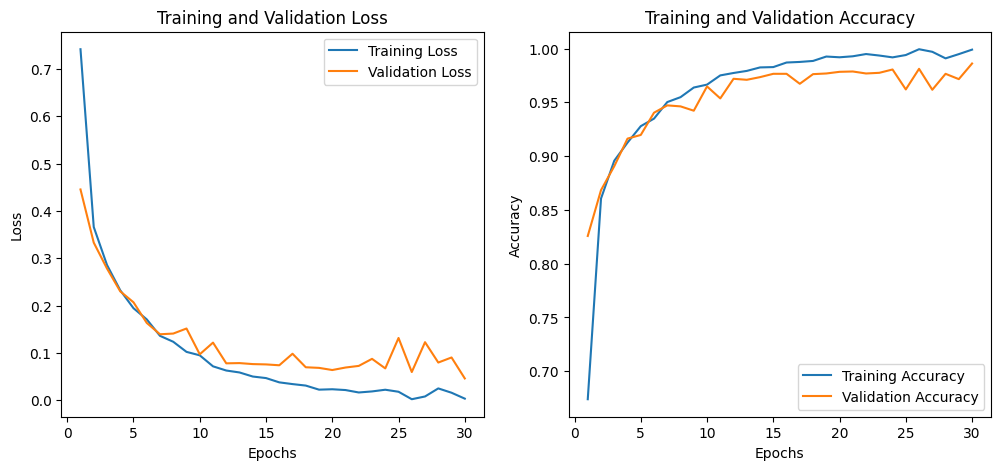

In [6]:
# Getting training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

# Plotting graphs
plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()